# Modules and Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint
import timeit
import time
import numba as nb
from scipy.ndimage import convolve
import scipy.io
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.ticker import ScalarFormatter
import imageio
from PIL import Image

# Functions

In [2]:
def model_derivative_nodorm(t, pop, pars, ls, Nsites, kernel):
    '''
    No Dormancy function
    Our systems function. It returns the change of the population densities per timestep
    '''
    # changing the population from (1, Nvar X ls X ls) dimensions that the system can manage to (Nvar, ls x ls) corresponding
    # with on list corresponding to every variable
    R = pop[:Nsites]
    S = pop[Nsites : 2*Nsites]
    Ii = pop[2*Nsites : (pars['n_I'] + 2)*Nsites]
    V = pop[(pars['n_I'] + 2)*Nsites : (pars['n_I'] + 3)*Nsites]
    
    # reshaping to square matrix
    R = np.reshape(R, (ls, ls))
    S = np.reshape(S, (ls, ls))
    Ii = np.reshape(Ii, (pars['n_I'], ls, ls))
    V = np.reshape(V, (ls, ls))
    
    # calculate diffusion by using convolutions (closed borders)
    DelR = convolve(R, kernel, mode='nearest')
    DelV = convolve(V, kernel, mode='nearest')
    
    #rates that are functions of R
    g_R = pars['r_max'] * (R/(pars['K_g'] + R)) # Monod's law for resources
    eta_R = pars['eta'] * (g_R / pars['g_R0'])
    
    #infected states
    dIi_dt= np.zeros_like(Ii)
    
    
    #our system
    dR_dt = - g_R*S + pars['D_R']*DelR
    dS_dt = g_R*S - pars['phi']*S*V
    dIi_dt[0,:,:] = pars['phi']*S*V - (eta_R*pars['n_I'])*Ii[0,:,:]
    dIi_dt[1:,:,:] = (eta_R*pars['n_I'])*Ii[:-1,:,:] - (eta_R*pars['n_I'])*Ii[1:,:,:]
    dV_dt = pars['beta']*(eta_R*pars['n_I'])*Ii[-1,:,:] - pars['phi']*(S+np.sum(Ii, axis=0))*V - pars['omega']*V + pars['D_V']*DelV
    
    #reshaping it back to the form that integrator can handle
    derivatives = np.zeros_like(pop)
    
    derivatives[:Nsites] = np.ravel(dR_dt)
    derivatives[Nsites : 2*Nsites] = np.ravel(dS_dt)
    derivatives[2*Nsites : (pars['n_I'] + 2)*Nsites] = np.ravel(dIi_dt)
    derivatives[(pars['n_I'] + 2)*Nsites : (pars['n_I'] + 3)*Nsites] = np.ravel(dV_dt)
    
    
    return derivatives

In [3]:
def model_derivative_dorm(t, pop, pars, ls, Nsites, kernel):
    '''
    Dormancy function
    Our systems function. It returns the change of the population densities per timestep
    '''
    # changing the population from (1, Nvar X ls X ls) dimensions that the system can manage to (Nvar, ls x ls) corresponding
    # with on list corresponding to every variable
    R = pop[:Nsites]
    S = pop[Nsites : 2*Nsites]
    M = pop[2*Nsites : 3*Nsites]
    Ii = pop[3*Nsites : (pars['n_I'] + 3)*Nsites]
    V = pop[(pars['n_I'] + 3)*Nsites : (pars['n_I'] + 4)*Nsites]
    Ei = pop[(pars['n_I'] + 4)*Nsites : (pars['n_I'] + pars['n_E'] + 4)*Nsites]
    D = pop[(pars['n_I'] + pars['n_E'] + 4)*Nsites : (pars['n_I'] + pars['n_E'] + 5)*Nsites]
    
    # reshaping to square matrix
    R = np.reshape(R, (ls, ls))
    S = np.reshape(S, (ls, ls))
    M = np.reshape(M, (ls, ls))
    Ii = np.reshape(Ii, (pars['n_I'], ls, ls))
    V = np.reshape(V, (ls, ls))
    Ei = np.reshape(Ei, (pars['n_E'], ls, ls))
    D = np.reshape(D, (ls, ls))
    
    # calculate diffusion by using convolutions (closed borders)
    DelR = convolve(R, kernel, mode='nearest')
    DelV = convolve(V, kernel, mode='nearest')
    DelM = convolve(M, kernel, mode='nearest')
    
    #rates that are functions of R
    g_R = pars['r_max'] * (R/(pars['K_g'] + R)) # Monod's law for resources
    eta_R = pars['eta'] * (g_R/pars['g_R0'])
    f_R = pars['d_max']/(1+np.exp(pars['s']*(R-pars['sigma'])))
    
    #infected states
    dIi_dt = np.zeros_like(Ii)
    dEi_dt = np.zeros_like(Ei)
    
    #our system
    dR_dt = - g_R*(S+np.sum(Ei, axis=0)) + pars['D_R']*DelR
    dS_dt = g_R*S - pars['phi']*S*V - f_R*S - pars['mu']*M*S
    dM_dt = pars['m']*(eta_R*pars['n_I'])*Ii[-1,:,:] - pars['mu']*M*S + pars['D_M']*DelM
    dIi_dt[0,:,:] = pars['phi']*(S+np.sum(Ei, axis=0))*V - (eta_R*pars['n_I'])*Ii[0,:,:]
    dIi_dt[1:,:,:] = (eta_R*pars['n_I'])*Ii[:-1,:,:] - (eta_R*pars['n_I'])*Ii[1:,:,:]
    dV_dt = pars['beta']*(eta_R*pars['n_I'])*Ii[-1,:,:] - pars['phi']*(S+np.sum(Ii, axis=0)+np.sum(Ei, axis=0))*V - pars['omega']*V + pars['D_V']*DelV
    dEi_dt[0,:,:] = f_R*S + pars['mu']*M*S - (pars['n_E']*pars['lambda'])*Ei[0,:,:] - pars['phi']*Ei[0,:,:]*V
    dEi_dt[1:,:,:] = (pars['n_E']*pars['lambda'])*Ei[:-1,:,:] - (pars['n_E']*pars['lambda'])*Ei[1:,:,:] - pars['phi']*Ei[1:,:,:]*V
    dD_dt = (pars['n_E']*pars['lambda'])*Ei[-1,:,:]
    
    #reshaping it back to the form that integrator can handle
    derivatives = np.zeros_like(pop)
    
    derivatives[:Nsites] = np.ravel(dR_dt)
    derivatives[Nsites : 2*Nsites] = np.ravel(dS_dt)
    derivatives[2*Nsites : 3*Nsites] = np.ravel(dM_dt)
    derivatives[3*Nsites : (pars['n_I'] + 3)*Nsites] = np.ravel(dIi_dt)
    derivatives[(pars['n_I'] + 3)*Nsites : (pars['n_I'] + 4)*Nsites] = np.ravel(dV_dt)
    derivatives[(pars['n_I'] + 4)*Nsites : (pars['n_I'] + pars['n_E'] + 4)*Nsites] = np.ravel(dEi_dt)
    derivatives[(pars['n_I'] + pars['n_E'] + 4)*Nsites : (pars['n_I'] + pars['n_E'] + 5)*Nsites] = np.ravel(dD_dt)
    
    return derivatives

# Definition and initiation of parameters

In [4]:
# check the paper for estimation of the parameters
pars = {}
pars['r_max'] = 2 # meaning:Maximum bacterial growth rate - units:1/hrs
pars['K_g'] = 3200 * 10**(6) # meaning:Monod constant - units:cells/mL
pars['D_R'] = 4*10**5 # meaning:Resource diffusion constant - units:μm^2/hrs
pars['D_V'] = 2*10**3 # meaning:Phage diffusion constant - units:μm^2/hrs
pars['D_M'] = 4*10**5 # meaning:Molecule diffusion constant - units:μm^2/hrs
pars['phi'] = 1.8*10**(-8) # meaning:Infection rate - units:mL/(hrs*viruses)
pars['beta'] = 100 # meaning:Burst size - units:viruses/cells
pars['eta'] = 4/3 # meaning:Max latent rate - units:1/hrs
pars['omega'] = 10**(-3) # meaning:Viral decay - units:1/hrs
pars['sigma'] = 0.2*pars['K_g'] # meaning:Resource dependent dormancy initiation threshold - units:cells/mL
pars['s'] = 10**(-7) # meaning:”Sharpness” of transition to dormancy - units:mL/cells
pars['lambda'] = 4/3 # meaning:Rate of switch to dormancy - units:1/hrs
pars['n_I'] = 10 # meaning:Number of infected states 
pars['n_E'] = 10 # meaning:Number of transitional/exposed states
pars['d_max'] = 1 # meaning:Maximum transition to dormancy rate - units:1/hrs
pars['m'] = 10**4 # meaning:Number of released messenger molecules
pars['mu'] = 5*10**(-11) # meaning:Molecule-susceptible cells interaction constant - units:mL/(hrs*cells)

#lattice features
L = 5000 # meaning:Lattice size - units:μm
dx = 50 # meaning:Distance between neighboring sites - units:μm
ls = int(L/dx) + 1
# sites
Nsites = ls*ls

# time 
t0 = 0 # meaning:Initial time point - units:hrs
tf = 15 # meaning:Final time point - units:hrs
t_ev = np.linspace(t0, tf, 1501) #time-steps. Each timestep is 0.001 hrs

#kernel/stencil for the convolution (for diffusion)
kernel = (1/dx**2)*np.array([[0.25, 0.5, 0.25],
                             [0.5, -3, 0.5], 
                             [0.25, 0.5, 0.25]])

# initiation of population densities (including resources)
R0 = 10**6 * 1000 * np.ones([Nsites]) # meaning:Initial resources - units:cells/mL
S0 = 10**7 * np.ones([Nsites]) # meaning:Initial bacterial population - units:cells/mL
M0 = np.zeros([Nsites]) # meaning:Initial density of molecule - unit:molecules/mL
I0 = pars['n_I']*[np.zeros([Nsites])] # meaning:Initial infected bacteria population - units:cells/mL
V0 = np.zeros([Nsites]) 
V0[int(Nsites/2)] = 10**6  #meaning:Initial viral density (1 phage per plaque) - units:viruses/mL
E0 = pars['n_E']*[np.zeros([Nsites])] # meaning:Initial density of bacteria on the process of transitioning to dormancy - units: cells/mL
D0 = np.zeros([Nsites]) # meaning:Initial dormant cell density - units:cells/mL
#shape the matrices for the forthcoming manipulations
R0_m = np.reshape(R0, (ls, ls))
pars['g_R0'] = pars['r_max'] * (R0_m/(pars['K_g'] + R0_m)) # calculating initial growth rate according to Monod's law

pop01 = np.vstack([R0, S0, I0, V0])
pop02 = np.vstack([R0, S0, M0, I0, V0, E0, D0])
Nvar1 = len(pop01) # number of systems variables
Nvar2 = len(pop02)

pop1 = np.hstack(pop01)
pop2 = np.hstack(pop02)

# Solving our PDE systems

In [5]:
# Solving the system for the case where the cells cannot switch to dormancy (ND or S^(-))
t_start = timeit.default_timer()
sol_ND = solve_ivp(model_derivative_nodorm, (t0, tf), pop1, args=(pars, ls, Nsites, kernel), max_step = 10**(-2), rtol=10**(-8), atol=10**(-8), t_eval = t_ev)
print(timeit.default_timer() - t_start)

113.05921649999999


In [6]:
# Solving the system for the case where the cells can switch to dormancy (D or S^(+))
t_start = timeit.default_timer()
sol_D = solve_ivp(model_derivative_dorm, (t0, tf), pop2, args=(pars, ls, Nsites, kernel), max_step = 10**(-2), rtol=10**(-8), atol=10**(-8), t_eval = t_ev)
print(timeit.default_timer() - t_start)

227.9977541


In [7]:
# The time series of the solution for the case where the cells cannot switch to dormancy (ND or S^(-))
pop_end_ND = np.reshape(sol_ND.y.T, (len(sol_ND.t), Nvar1, ls*ls))
R_end_ND = pop_end_ND[:, 0]
S_end_ND = pop_end_ND[:, 1]
I_end_ND = np.sum(pop_end_ND[:, (1+pars['n_I']):(-1)], axis=1)
V_end_ND = pop_end_ND[:, -1]
R_end_ND = np.reshape(R_end_ND, (len(sol_ND.t), ls, ls))
S_end_ND = np.reshape(S_end_ND, (len(sol_ND.t), ls, ls))
I_end_ND = np.reshape(I_end_ND, (len(sol_ND.t), ls, ls))
V_end_ND = np.reshape(V_end_ND, (len(sol_ND.t), ls, ls))

In [8]:
All_cells_ND = S_end_ND + I_end_ND

In [9]:
# The time series of the solution for the case where the cells can switch to dormancy (D or S^(+))
pop_end_D = np.reshape(sol_D.y.T, (len(sol_D.t), Nvar2, ls*ls))
R_end_D = pop_end_D[:, 0]
S_end_D = pop_end_D[:, 1]
M_end_D = pop_end_D[:, 2]
I_end_D = np.sum(pop_end_D[:, (2+pars['n_I']):(-2-pars['n_E'])], axis=1)
V_end_D = pop_end_D[:, (-2-pars['n_E'])]
E_end_D = np.sum(pop_end_D[:, (-1-pars['n_E']):-1], axis=1)
D_end_D = pop_end_D[:, -1]
R_end_D = np.reshape(R_end_D, (len(sol_D.t), ls, ls))
S_end_D = np.reshape(S_end_D, (len(sol_D.t), ls, ls))
M_end_D = np.reshape(M_end_D, (len(sol_D.t), ls, ls))
I_end_D = np.reshape(I_end_D, (len(sol_D.t), ls, ls))
V_end_D = np.reshape(V_end_D, (len(sol_D.t), ls, ls))
E_end_D = np.reshape(E_end_D, (len(sol_D.t), ls, ls))
D_end_D = np.reshape(D_end_D, (len(sol_D.t), ls, ls))

In [10]:
All_cells_D = S_end_D + I_end_D + E_end_D + D_end_D

# Plotting our results to compare sporulating $S^{+}$ to non-sporulating $S^{-}$ bacteria

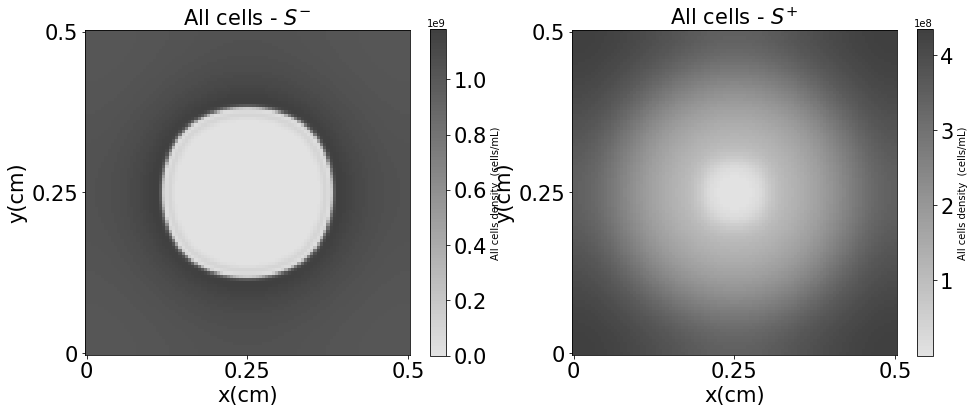

In [11]:
'''Impact of sporulation on plaque size'''
fig, ax = plt.subplots(1,2,figsize=[16,6])
ax = np.ravel(ax)
step = 1500

# Get the 'Greys' colormap
greys = plt.get_cmap('Greys_r')

# Extract colors from the existing colormap
light_grey = greys(0.8)  # Extract lighter grey (closer to white)
less_dark_grey = greys(0.2)  # Extract less dark grey (closer to black)

# Create a custom colormap
colors = [light_grey, less_dark_grey]
n_bins = 100
new_greys = LinearSegmentedColormap.from_list('truncated_greys', colors, N=n_bins)

fig.colorbar(ax[0].imshow(All_cells_ND[step], cmap=new_greys), ax=ax[0], label='All cells density  (cells/mL)')
fig.colorbar(ax[1].imshow(All_cells_D[step], cmap=new_greys), ax=ax[1], label='All cells density  (cells/mL)')

ax[0].imshow(All_cells_ND[step], cmap=new_greys).figure.axes[2].tick_params(axis='both', labelsize=21);
ax[0].imshow(All_cells_ND[step], cmap=new_greys).figure.axes[0].tick_params(axis='both', labelsize=21);
ax[0].set_title('All cells - $S^{-}$', fontsize=21);
ax[0].set_xlabel('x(cm)', fontsize=21)
ax[0].set_ylabel('y(cm)', fontsize=21)

# Determine the number of ticks needed for each axis
num_ticks_x = 3
num_ticks_y = 3
# Calculate tick positions
tick_positions_x = np.linspace(0, All_cells_ND[step].shape[1]-1, num_ticks_x)
tick_positions_y = np.linspace(0, All_cells_ND[step].shape[0]-1, num_ticks_y)
# Set tick positions and labels for x-axis
ax[0].set_xticks(tick_positions_x)
ax[0].set_xticklabels(['0', '0.25', '0.5'])
# Set tick positions and labels for y-axis
ax[0].set_yticks(tick_positions_y)
ax[0].set_yticklabels(['0', '0.25', '0.5'])
# Invert the y-axis
ax[0].invert_yaxis()



ax[1].imshow(All_cells_D[step], cmap=new_greys).figure.axes[1].tick_params(axis='both', labelsize=21);
ax[1].imshow(All_cells_D[step], cmap=new_greys).figure.axes[3].tick_params(axis='both', labelsize=21);
ax[1].set_title('All cells - $S^{+}$', fontsize=21);
ax[1].set_xlabel('x(cm)', fontsize=21)
ax[1].set_ylabel('y(cm)', fontsize=21)

# Determine the number of ticks needed for each axis
num_ticks_x = 3
num_ticks_y = 3
# Calculate tick positions
tick_positions_x = np.linspace(0, All_cells_ND[step].shape[1]-1, num_ticks_x)
tick_positions_y = np.linspace(0, All_cells_ND[step].shape[0]-1, num_ticks_y)
# Set tick positions and labels for x-axis
ax[1].set_xticks(tick_positions_x)
ax[1].set_xticklabels(['0', '0.25', '0.5'])
# Set tick positions and labels for y-axis
ax[1].set_yticks(tick_positions_y)
ax[1].set_yticklabels(['0', '0.25', '0.5'])
# Invert the y-axis
ax[1].invert_yaxis()


In [12]:
plaque_size_ND = []
plaque_size_D = []
for i in range(len(t_ev)):
    Sum_ND = 0
    Sum_D = 0
    if t_ev[i] < 2:
        plaque_size_ND.append(Sum_ND)
        plaque_size_D.append(Sum_D)
    else:
        for j in range(int(ls/2), ls):
            if All_cells_ND[i,int(ls/2),j] < np.max(All_cells_ND[i,int(ls/2),:])/10:
                Sum_ND += dx/10000

            if All_cells_D[i,int(ls/2),j] < np.max(All_cells_D[i,int(ls/2),:])/10:
                Sum_D += dx/10000
    
        plaque_size_ND.append(Sum_ND)
        plaque_size_D.append(Sum_D)

In [13]:
'''Experimental data'''
NS_exp_data = scipy.io.loadmat('Sminus_data.mat')['areas']
S_exp_data = scipy.io.loadmat('Splus_data.mat')['areas']
print(NS_exp_data.shape)
NS_areas = NS_exp_data.copy()
NS_exp_plaque_radii = np.sqrt(NS_areas/np.pi)
S_areas = S_exp_data.copy()
S_exp_plaque_radii = np.sqrt(S_areas/np.pi)

NS_exp_plaque_radii_cm = 0.007*NS_exp_plaque_radii
S_exp_plaque_radii_cm = 0.007*S_exp_plaque_radii

time_exp = np.linspace(25/60, (178*5)/60 + 25/60, 179)

NS_mean_radius = np.mean(NS_exp_plaque_radii_cm,1)
S_mean_radius = np.mean(S_exp_plaque_radii_cm,1)

NS_error = np.std(NS_exp_plaque_radii_cm,1)
S_error = np.std(S_exp_plaque_radii_cm,1);

(179, 46)


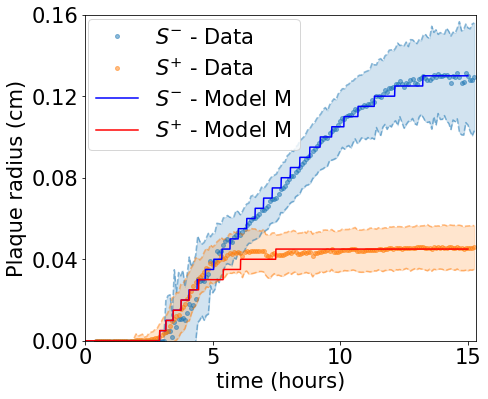

In [14]:
'''Impact of sporulation on plaque size'''
fig, ax = plt.subplots(figsize=[7,6])

#experimental plots
ax.plot(time_exp, NS_mean_radius, 'o', color='C0', markersize=4, alpha=0.5, label='$S^{-}$ - Data')
ax.fill_between(time_exp, NS_mean_radius - NS_error, NS_mean_radius + NS_error, color='C0', alpha=0.2)
# Add intermittent lines at the upper and lower boundaries
ax.plot(time_exp, NS_mean_radius - NS_error, linestyle='--', color='C0', alpha=0.5)
ax.plot(time_exp, NS_mean_radius + NS_error, linestyle='--', color='C0', alpha=0.5)

ax.plot(time_exp, S_mean_radius, 'o', color='C1', markersize=4, alpha=0.5, label='$S^{+}$ - Data')
ax.fill_between(time_exp, S_mean_radius - S_error, S_mean_radius + S_error, color='C1', alpha=0.2)
# Add intermittent lines at the upper and lower boundaries
ax.plot(time_exp, S_mean_radius - S_error, linestyle='--', color='C1', alpha=0.5)
ax.plot(time_exp, S_mean_radius + S_error, linestyle='--', color='C1', alpha=0.5)

#theoretical plots
ax.plot(t_ev, plaque_size_ND, color='blue', label='$S^{-}$ - Model M')
ax.plot(t_ev, plaque_size_D, color='red', label='$S^{+}$ - Model M' )

ax.set_xlabel('time (hours)',fontsize=21)
ax.set_ylabel("Plaque radius (cm)",fontsize=21)
ax.set_xlim([0,15.3])
ax.set_ylim([0,0.15])

ax.tick_params(labelsize=21)
ax.legend(loc='upper left', bbox_to_anchor=(-0.02, 1.02), fontsize=21)

ax.set_yticks([0, 0.04, 0.08, 0.12, 0.16]);

#fig.savefig('Figure Modeling 1 D.png')

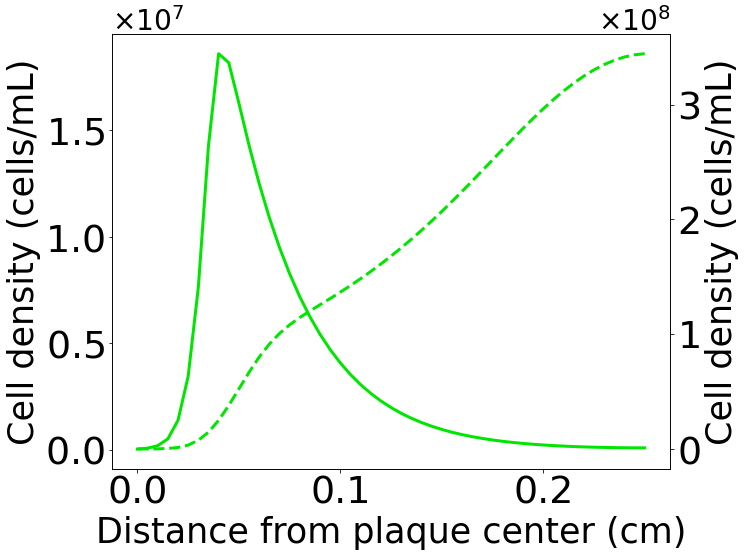

In [16]:
'''Simulated plaque growth and distribution of dormant cells for the $S^{+}$ host'''
step1 = 500
step2 = 1500
fig, ax = plt.subplots(figsize=[10,8])
ax.plot(dx/10000*np.arange(int(ls/2)+1), D_end_D[step1, int(ls/2), int(ls/2):], color=(0, 0.9, 0), lw=3, label='t = 5 hrs')
# Create a second y-axis and plot data on it
ax2 = ax.twinx()
ax2.plot(dx/10000*np.arange(int(ls/2)+1), D_end_D[step2, int(ls/2), int(ls/2):], color=(0, 0.9, 0), linestyle='--', lw=3, label='t = 15 hrs')
ax.set_xlabel('Distance from plaque center (cm)', fontsize=35)
ax.set_ylabel('Cell density (cells/mL)', fontsize=35)
ax.tick_params(axis='both', labelsize=38)
ax2.set_ylabel('Cell density (cells/mL)', fontsize=35)
ax2.tick_params(axis='both', labelsize=38)

# Adjust the format of the tick labels
formatter = ScalarFormatter(useMathText=True)
ax.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax.yaxis.offsetText.set_fontsize(28)
ax2.yaxis.offsetText.set_fontsize(28)

# Create a single legend for both lines
# fig.legend(loc='upper left', bbox_to_anchor=(0.42, 0.5), fontsize=35);

#fig.savefig('Figure Modeling 2 NEW J.pdf', bbox_inches='tight', pad_inches=0);

<ipython-input-17-10d23fdebe68>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labelsy);
<ipython-input-17-10d23fdebe68>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labelsx);


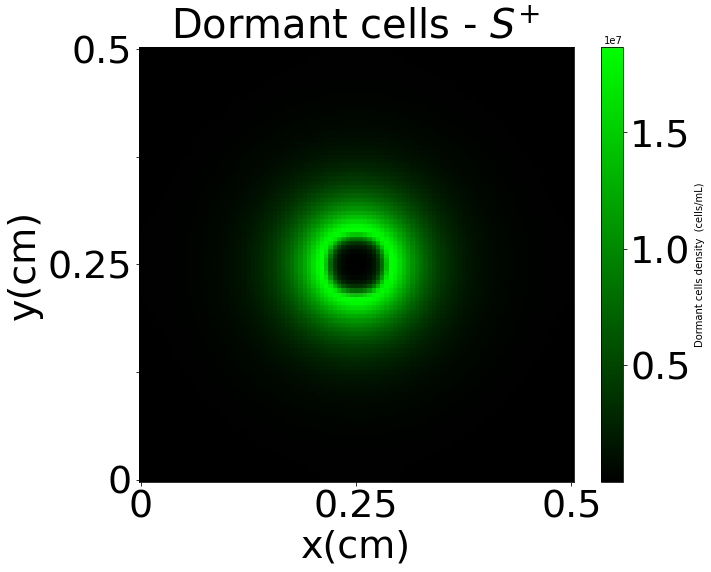

In [17]:
'''Simulated plaque growth and distribution of dormant cells for the $S^{+}$ host'''
fig, ax = plt.subplots(figsize=[10,8])
step = 500

# Define the colors for the custom colormap
colors = [(0, 0, 0), (0, 1, 0)]  # Black to Green
n_bins = 500  # Discretizes the interpolation into bins
cmap_name = 'custom_black_to_green'
new_greens = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

fig.colorbar(ax.imshow(D_end_D[step], cmap=new_greens), ax=ax, label='Dormant cells density  (cells/mL)')

ax.imshow(D_end_D[step], cmap=new_greens).figure.axes[0].tick_params(axis='both', labelsize=38);
ax.imshow(D_end_D[step], cmap=new_greens).figure.axes[1].tick_params(axis='both', labelsize=38);

ax.set_title('Dormant cells - $S^{+}$', fontsize=40);
ax.set_xlabel('x(cm)', fontsize=38)
ax.set_ylabel('y(cm)', fontsize=38)
labelsy = [item.get_text() for item in ax.get_xticklabels()]
labelsx = [item.get_text() for item in ax.get_xticklabels()]

# for the specific fontsize
labelsy = [str(0),str(0), str(), str(50*0.005), str(), str(100*0.005)]

#for specific fontsize
labelsx = [str(0),str(0), str(50*0.005), str(100*0.005)]
ax.set_yticklabels(labelsy);
ax.set_xticklabels(labelsx);
# Invert the y-axis
plt.gca().invert_yaxis()
#fig.savefig('Figure Modeling 2 N.pdf', bbox_inches='tight', pad_inches=0);

<ipython-input-18-800ed70b52d8>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labelsy);
<ipython-input-18-800ed70b52d8>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labelsx);


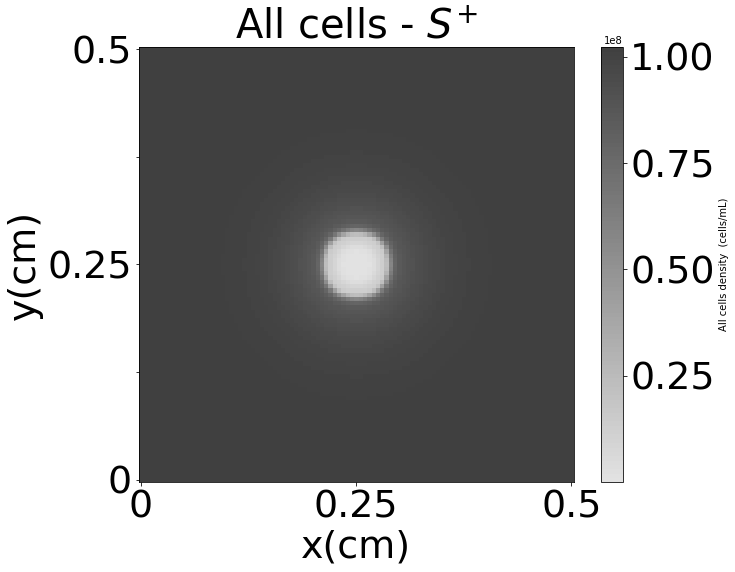

In [18]:
'''Simulated plaque growth and distribution of dormant cells for the $S^{+}$ host'''
fig, ax = plt.subplots(figsize=[10,8])
step = 500

# Get the 'Greys' colormap
greys = plt.get_cmap('Greys_r')

# Extract colors from the existing colormap
light_grey = greys(0.8)  # Extract lighter grey (closer to white)
less_dark_grey = greys(0.2)  # Extract less dark grey (closer to black)

# Create a custom colormap
colors = [light_grey, less_dark_grey]
n_bins = 100
new_greys = LinearSegmentedColormap.from_list('truncated_greys', colors, N=n_bins)

fig.colorbar(ax.imshow(All_cells_D[step], cmap=new_greys), ax=ax, label='All cells density  (cells/mL)')

ax.imshow(All_cells_D[step], cmap=new_greys).figure.axes[0].tick_params(axis='both', labelsize=38);
ax.imshow(All_cells_D[step], cmap=new_greys).figure.axes[1].tick_params(axis='both', labelsize=38);

ax.set_title('All cells - $S^{+}$', fontsize=40);
ax.set_xlabel('x(cm)', fontsize=38)
ax.set_ylabel('y(cm)', fontsize=38)
labelsy = [item.get_text() for item in ax.get_xticklabels()]
labelsx = [item.get_text() for item in ax.get_xticklabels()]

# for the specific fontsize
labelsy = [str(0),str(0), str(), str(50*0.005), str(), str(100*0.005)]

#for specific fontsize
labelsx = [str(0),str(0), str(50*0.005), str(100*0.005)]
ax.set_yticklabels(labelsy);
ax.set_xticklabels(labelsx);
# Invert the y-axis
plt.gca().invert_yaxis()
#fig.savefig('Figure Modeling 2 M.pdf', bbox_inches='tight', pad_inches=0);